https://h1ros.github.io/posts/explain-image-classification-by-shap-deep-explainer/

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_9747/1427053569.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [17]:
from matplotlib                          import pyplot
from matplotlib.image                    import imread
from torchvision.datasets                import ImageFolder
from torch.optim.lr_scheduler            import OneCycleLR
from sklearn.metrics                     import r2_score


import numpy                  as np
import matplotlib.pyplot      as plt
import matplotlib.image       as mpimg
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchinfo


import torch
import os
import random
import matplotlib
import torchvision
import torchinfo
import gc 
import os
import time


In [4]:
DATA_PATH = '../../data'
oTrainSet = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

oTrainSet.data.shape, oTrainSet[0][0].shape

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [5]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

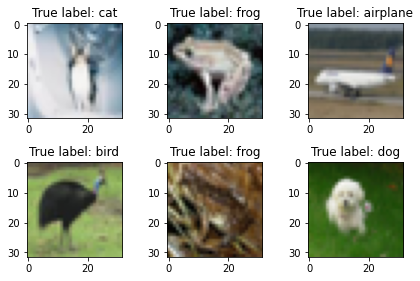

In [6]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(6, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow   (np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

In [7]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


In [8]:
oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

In [19]:
batchSize = 512
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX, vY    = next(iter(oTrainDL))
mX.shape

torch.Size([512, 3, 32, 32])

In [20]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(DEVICE)

cuda:0


In [23]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(3,   16,  3, bias=False),           nn.BatchNorm2d(16),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(16,  32,  3, bias=False),           nn.BatchNorm2d(32),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(32,  64,  3, bias=False, stride=2), nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(64,  128, 3, bias=False),           nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(128, 256, 3, bias=False, stride=2), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(256, 512, 3, bias=False),           nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout2d(0.1),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),
        nn.Linear           (512, 256),
        nn.Linear           (256, 128),
        nn.Linear           (128, 10),
    )
    
    return oModel

torchinfo.summary(GetModel(), (512, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [512, 3, 32, 32]          --
├─Conv2d: 1-2                            [512, 16, 30, 30]         432
├─BatchNorm2d: 1-3                       [512, 16, 30, 30]         32
├─ReLU: 1-4                              [512, 16, 30, 30]         --
├─Dropout2d: 1-5                         [512, 16, 30, 30]         --
├─Conv2d: 1-6                            [512, 32, 28, 28]         4,608
├─BatchNorm2d: 1-7                       [512, 32, 28, 28]         64
├─ReLU: 1-8                              [512, 32, 28, 28]         --
├─Dropout2d: 1-9                         [512, 32, 28, 28]         --
├─Conv2d: 1-10                           [512, 64, 13, 13]         18,432
├─BatchNorm2d: 1-11                      [512, 64, 13, 13]         128
├─ReLU: 1-12                             [512, 64, 13, 13]         --
├─Drop

In [13]:
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [14]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
                
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)                        
            loss = Loss(mZ, vY)           
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)                
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [15]:
def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, Epoch=Epoch, sModelName='BestParams'):

    vTrainLoss   = np.full(nEpochs, np.nan)
    vTrainMetric = np.full(nEpochs, np.nan)
    vValLoss     = np.full(nEpochs, np.nan)
    vValMetric   = np.full(nEpochs, np.nan)
    vLR          = np.full(0,       np.nan)
    bestMetric   = -float('inf')

    for epoch in range(nEpochs):
        startTime                    = time.time()
        trainLoss, trainMetric, vLRi = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valMetric,   _    = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime                    = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch       :03d}:',   end='')
        print(' | Train loss: '   f'{trainLoss   :6.3f}',   end='')
        print(' | Val loss: '     f'{valLoss     :6.3f}',   end='')
        print(' | Train Metric: ' f'{trainMetric :6.3f}',   end='')
        print(' | Val Metric: '   f'{valMetric   :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime   :6.3f} |', end='')

        vTrainLoss  [epoch] = trainLoss
        vTrainMetric[epoch] = trainMetric
        vValLoss    [epoch] = valLoss
        vValMetric  [epoch] = valMetric
        vLR                 = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return vTrainLoss, vTrainMetric, vValLoss, vValMetric, vLR

In [24]:
nEpochs    = 30
nIter      = nEpochs * len(oTrainDL)
Loss       = nn.CrossEntropyLoss()
Metric     = Accuracy
oModel     = GetModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, 
                        oOptim, oScheduler, Epoch=Epoch, sModelName='CFAR10-CNN')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  1.639 | Val loss:  1.371 | Train Metric:  0.393 | Val Metric:  0.508 | epoch time:  6.005 | <-- Checkpoint!
Epoch 001: | Train loss:  1.298 | Val loss:  1.117 | Train Metric:  0.529 | Val Metric:  0.591 | epoch time:  5.916 | <-- Checkpoint!
Epoch 002: | Train loss:  1.146 | Val loss:  0.997 | Train Metric:  0.592 | Val Metric:  0.649 | epoch time:  5.985 | <-- Checkpoint!
Epoch 003: | Train loss:  1.027 | Val loss:  0.977 | Train Metric:  0.639 | Val Metric:  0.655 | epoch time:  5.990 | <-- Checkpoint!
Epoch 004: | Train loss:  0.927 | Val loss:  0.891 | Train Metric:  0.677 | Val Metric:  0.696 | epoch time:  5.986 | <-- Checkpoint!
Epoch 005: | Train loss:  0.854 | Val loss:  0.842 | Train Metric:  0.703 | Val Metric:  0.713 | epoch time:  5.979 | <-- Checkpoint!
Epoch 006: | Train loss:  0.765 | Val loss:  0.737 | Train Metric:  0.737 |

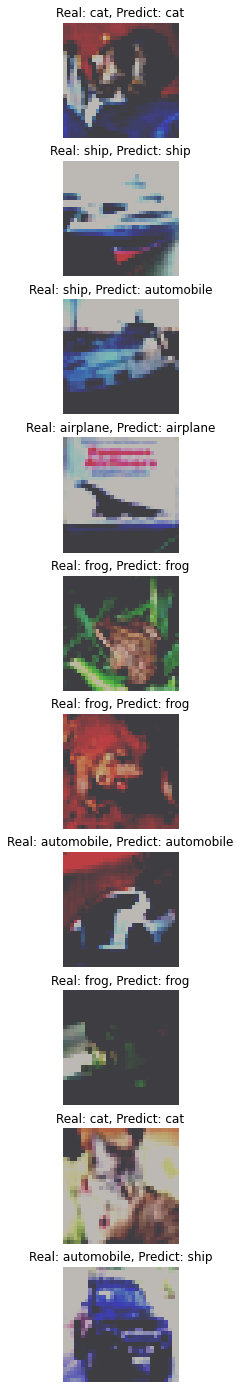

In [89]:
oModel = GetModel     ().to(DEVICE)
oModel.load_state_dict(torch.load('CFAR10-CNN.pt'))
oModel.train(False) 

mX, vY = next(iter(oTestDL))
mX     = mX.to(DEVICE)
hatY   = oModel(mX)

#hatY = hatY.squeeze().cpu().detach().numpy()
y    = vY.cpu().numpy()

f, axarr = plt.subplots(10,1,figsize=(25,25))

for i in range(len(y)):   
   
    # get predicted label (with max probablilty) 
    vProb  = torch.softmax(hatY, dim=0)
    
    idx    = torch.argmax (hatY[i])
    idx    = idx.cpu().numpy()
   
    axarr[i].set_title(f"Real: {lClasses[y[i]]}, Predict: {lClasses[idx]}")
    img = mX[i].cpu()   
    img = np.transpose(img.numpy(), (1,2,0))
    #img = img.permute(1,2,0).numpy()  
    img = np.clip(img, 0, 1)
    img = img*vMean+vStd    
    
    axarr[i].imshow(img)
    axarr[i].axis('off')
    
    if i == 9:
        break

    

In [39]:
import shap
shap.initjs()

In [90]:

mX, vY = next(iter(oTrainDL))
mX     = mX.to(DEVICE)
oSHAP  = shap.DeepExplainer(oModel, mX[:256])

In [91]:
test_images = mX[256:256+2]
shap_values = oSHAP.shap_values(test_images)

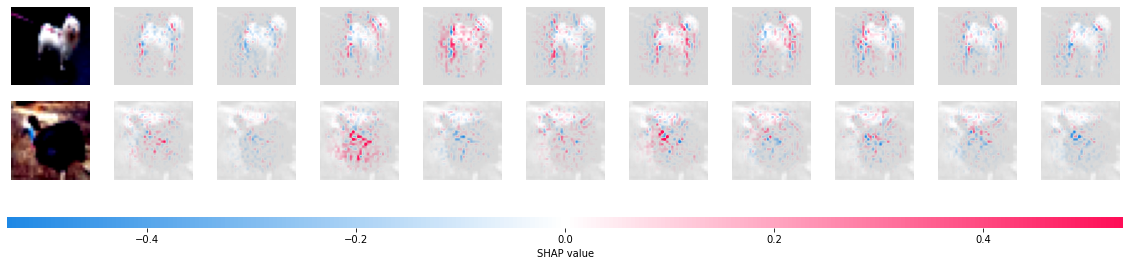

In [101]:
r           = random.randint(1, 100)
test_images = mX[256+r:256+r+2]
shap_numpy  = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_images = test_images.cpu().permute(0,2,3,1).numpy()*vMean+vStd
test_images = np.clip(test_images, 0, 1)
shap.image_plot(shap_numpy, test_images)